In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats

import dask.dataframe as dd
from pathlib import Path
import glob

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/activity")

In [3]:
import subsampling as ss
import activity.activity_assembly as actvt
from core import SITE_NAMES, FREQ_GROUPS

from cli import get_file_paths
import plot
import pipeline

In [4]:
import suncalc

import activity.activity_assembly as actvt

from core import DC_COLOR_MAPPINGS, SEATTLE_LATITUDE, SEATTLE_LONGITUDE

In [5]:
avail = np.arange(0, 720, 6) + 6
reset_24 = avail[np.where((24*60 % avail) == 0)[0]]
reset_24

array([  6,  12,  18,  24,  30,  36,  48,  60,  72,  90,  96, 120, 144,
       180, 240, 288, 360, 480, 720])

In [6]:
def plot_activity_grid_for_dets(activity_arr, data_params, pipeline_params, file_paths):
    """
    Plots an activity grid generated from an activity summary for a specific duty-cycling scheme.
    The activity summary here is of the number of detections observed per date and time interval.
    """
    activity_df = actvt.construct_activity_grid_for_number_of_dets(activity_arr, data_params["cur_dc_tag"])

    activity_times = pd.DatetimeIndex(activity_df.index).tz_localize('UTC')
    activity_dates = pd.DatetimeIndex(activity_df.columns).strftime("%m/%d/%y")
    ylabel = 'UTC'
    if pipeline_params["show_PST"]:
        activity_times = activity_times.tz_convert(tz='US/Pacific')
        ylabel = 'PST'
    activity_times = activity_times.strftime("%H:%M")
    plot_times = [''] * len(activity_times)
    plot_times[2::4] = activity_times[2::4]
    plot_times[np.where(plot_times=='00:00')[0]] = 'Midnight'
    plot_dates = [''] * len(activity_dates)
    plot_dates[::7] = activity_dates[::7]

    dates_for_sunrise_sunset = pd.to_datetime(activity_df.columns.values, format='%m/%d/%y')
    activity_lat = [SEATTLE_LATITUDE]*len(dates_for_sunrise_sunset)
    activity_lon = [SEATTLE_LONGITUDE]*len(dates_for_sunrise_sunset)
    sunrise_time = pd.DatetimeIndex(suncalc.get_times(dates_for_sunrise_sunset, activity_lon, activity_lat)['sunrise_end'])
    sunset_time = pd.DatetimeIndex(suncalc.get_times(dates_for_sunrise_sunset, activity_lon, activity_lat)['sunset_start'])
    sunrise_seconds_from_midnight = sunrise_time.hour * 3600 + sunrise_time.minute*60 + sunrise_time.second
    sunset_seconds_from_midnight = sunset_time.hour * 3600 + sunset_time.minute*60 + sunset_time.second

    on = int(data_params['cur_dc_tag'].split('of')[0])
    total = int(data_params['cur_dc_tag'].split('of')[1])
    bin_size = int(data_params['bin_size'])
    recover_ratio = min(total, bin_size) / min(on, bin_size)

    if total-on >= bin_size:
        activity_df = activity_df.replace(np.NaN, -1).replace(0, np.NaN)
        activity_df = activity_df.ffill(limit=(min((14*60)-on, total-on)//bin_size))
        activity_df = activity_df.replace(np.NaN, 0).replace(-1, np.NaN)

    masked_array_for_nodets = np.ma.masked_where(activity_df.values==np.NaN, activity_df.values)
    cmap = plt.get_cmap('viridis')
    cmap.set_bad(color='red')
    plt.rcParams.update({'font.size': (0.8*len(activity_dates) + 0.8*len(activity_times))})
    plt.figure(figsize=(1*len(activity_dates), 1*len(activity_times)))
    title = f"Activity (# of low-frequency calls) from {data_params['site_name']}"
    # plt.title(title, fontsize=0.8*len(activity_dates) + 1.4*len(activity_times))
    plt.imshow(1+(recover_ratio*masked_array_for_nodets), cmap=cmap, norm=colors.LogNorm(vmin=1, vmax=10e3))
    plt.plot(np.arange(0, len(plot_dates)), ((sunset_seconds_from_midnight / (30*60)) % len(plot_times)) - 0.5, 
            color='white', linewidth=0.5*len(activity_times), linestyle='dashed', label=f'Time of Sunset')
    plt.axhline(y=np.where(activity_times=='00:00')[0]-0.5, linewidth=0.5*len(activity_times), linestyle='dashed', color='white', label='Midnight 0:00 PST')
    plt.plot(np.arange(0, len(plot_dates)), ((sunrise_seconds_from_midnight / (30*60)) % len(plot_times)) - 0.5, 
            color='white', linewidth=0.5*len(activity_times), linestyle='dashed', label=f'Time of Sunrise')
    plt.yticks(np.arange(0, len(activity_df.index))-0.5, plot_times, rotation=30)
    plt.xticks(np.arange(0, len(activity_df.columns))-0.5, plot_dates, rotation=30)
    plt.ylabel(f'{ylabel} Time (HH:MM)')
    plt.xlabel('Date (MM/DD/YY)')
    plt.grid(which='both', linewidth=2)
    # plt.legend(loc=3, ncol=3, fontsize=0.7*len(activity_dates) + 1*len(activity_times))
    plt.colorbar()
    plt.tight_layout()
    if pipeline_params["save_activity_grid"]:
        plt.savefig(f'{file_paths["activity_grid_folder"]}/{file_paths["activity_dets_grid_figname"]}.png', bbox_inches='tight')
        plt.close()
    if pipeline_params["show_plots"]:
        plt.show()

In [76]:
cycle_lengths = [10]
percent_ons = [1/2]
specific_dc_tag = "30of30"

data_params = dict()
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])
data_params["dc_tags"] = dc_tags
data_params["cur_dc_tag"] = specific_dc_tag
data_params['bin_size'] = '30'
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = False
pipeline_params["read_csv"] = True
pipeline_params['use_threshold_to_group'] = False
pipeline_params['use_kmeans_to_group'] = True
pipeline_params["save_activity_grid"] = False
pipeline_params["save_presence_grid"] = False
pipeline_params["save_dc_night_comparisons"] = False
pipeline_params["save_activity_dc_comparisons"] = True
pipeline_params["save_presence_dc_comparisons"] = True
pipeline_params["show_plots"] = True
pipeline_params["show_PST"] = True

site_key = 'Carp'
type_key = 'LF'
print(site_key, type_key)

data_params["site_name"] = SITE_NAMES[site_key]
data_params["site_tag"] = site_key
data_params["type_tag"] = type_key

file_paths = get_file_paths(data_params)

activity_dets_arr = pipeline.run_for_dets(data_params, pipeline_params, file_paths)
# plot_activity_grid_for_dets(activity_dets_arr, data_params, pipeline_params, file_paths)
activity_df = actvt.construct_activity_grid_for_number_of_dets(activity_dets_arr, data_params["cur_dc_tag"])

activity_times = pd.DatetimeIndex(activity_df.index).tz_localize('UTC')
activity_dates = pd.DatetimeIndex(activity_df.columns).strftime("%m/%d/%y")
ylabel = 'UTC'
if pipeline_params["show_PST"]:
    activity_times = activity_times.tz_convert(tz='US/Pacific')
    ylabel = 'PST'
activity_times = activity_times.strftime("%H:%M")
plot_times = [''] * len(activity_times)
# plot_times[2::4] = activity_times[2::4]
# plot_times[np.where(np.array(plot_times)=='00:00')[0][0]] = 'Midnight'
plot_dates = [''] * len(activity_dates)
# plot_dates[::7] = activity_dates[::7]

dates_for_sunrise_sunset = pd.to_datetime(activity_df.columns.values, format='%m/%d/%y')
activity_lat = [SEATTLE_LATITUDE]*len(dates_for_sunrise_sunset)
activity_lon = [SEATTLE_LONGITUDE]*len(dates_for_sunrise_sunset)
sunrise_time = pd.DatetimeIndex(suncalc.get_times(dates_for_sunrise_sunset, activity_lon, activity_lat)['sunrise_end'])
sunset_time = pd.DatetimeIndex(suncalc.get_times(dates_for_sunrise_sunset, activity_lon, activity_lat)['sunset_start'])
sunrise_seconds_from_midnight = sunrise_time.hour * 3600 + sunrise_time.minute*60 + sunrise_time.second
sunset_seconds_from_midnight = sunset_time.hour * 3600 + sunset_time.minute*60 + sunset_time.second

on = int(data_params['cur_dc_tag'].split('of')[0])
total = int(data_params['cur_dc_tag'].split('of')[1])
bin_size = int(data_params['bin_size'])
recover_ratio = min(total, bin_size) / min(on, bin_size)
activity_df

Carp LF


Date (UTC),07/13/22,07/14/22,07/15/22,07/16/22,07/17/22,07/18/22,07/19/22,07/20/22,07/21/22,07/22/22,...,10/08/22,10/09/22,10/10/22,10/11/22,10/12/22,10/13/22,10/14/22,10/15/22,10/16/22,10/17/22
Time (UTC),,,,,,,,,,,,,,,,,,,,,
00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
00:30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01:00,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01:30,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126.0
02:00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,129.0,1050.0,401.0,11.0,0.0,2.0,8.0,2.0,1097.0,802.0
02:30,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,...,983.0,622.0,227.0,8.0,0.0,127.0,761.0,0.0,1018.0,491.0
03:00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,764.0,4191.0,539.0,48.0,0.0,0.0,1035.0,0.0,197.0,381.0
03:30,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,796.0,893.0,956.0,0.0,0.0,0.0,0.0,8.0,0.0,91.0
04:00,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,...,187.0,1224.0,0.0,0.0,0.0,6.0,0.0,0.0,11.0,58.0


In [67]:
activity_df[(activity_df!=activity_df.iloc[16,15])&((activity_df>0))] = 0.0

In [65]:
activity_df[(activity_df!=activity_df.iloc[16,15])|(activity_df!=np.NaN)] = 0.0
activity_df

Date (UTC),07/13/22,07/14/22,07/15/22,07/16/22,07/17/22,07/18/22,07/19/22,07/20/22,07/21/22,07/22/22,...,10/08/22,10/09/22,10/10/22,10/11/22,10/12/22,10/13/22,10/14/22,10/15/22,10/16/22,10/17/22
Time (UTC),,,,,,,,,,,,,,,,,,,,,
00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00:30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01:30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02:30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
03:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
03:30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
04:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
recover_ratio

1.0

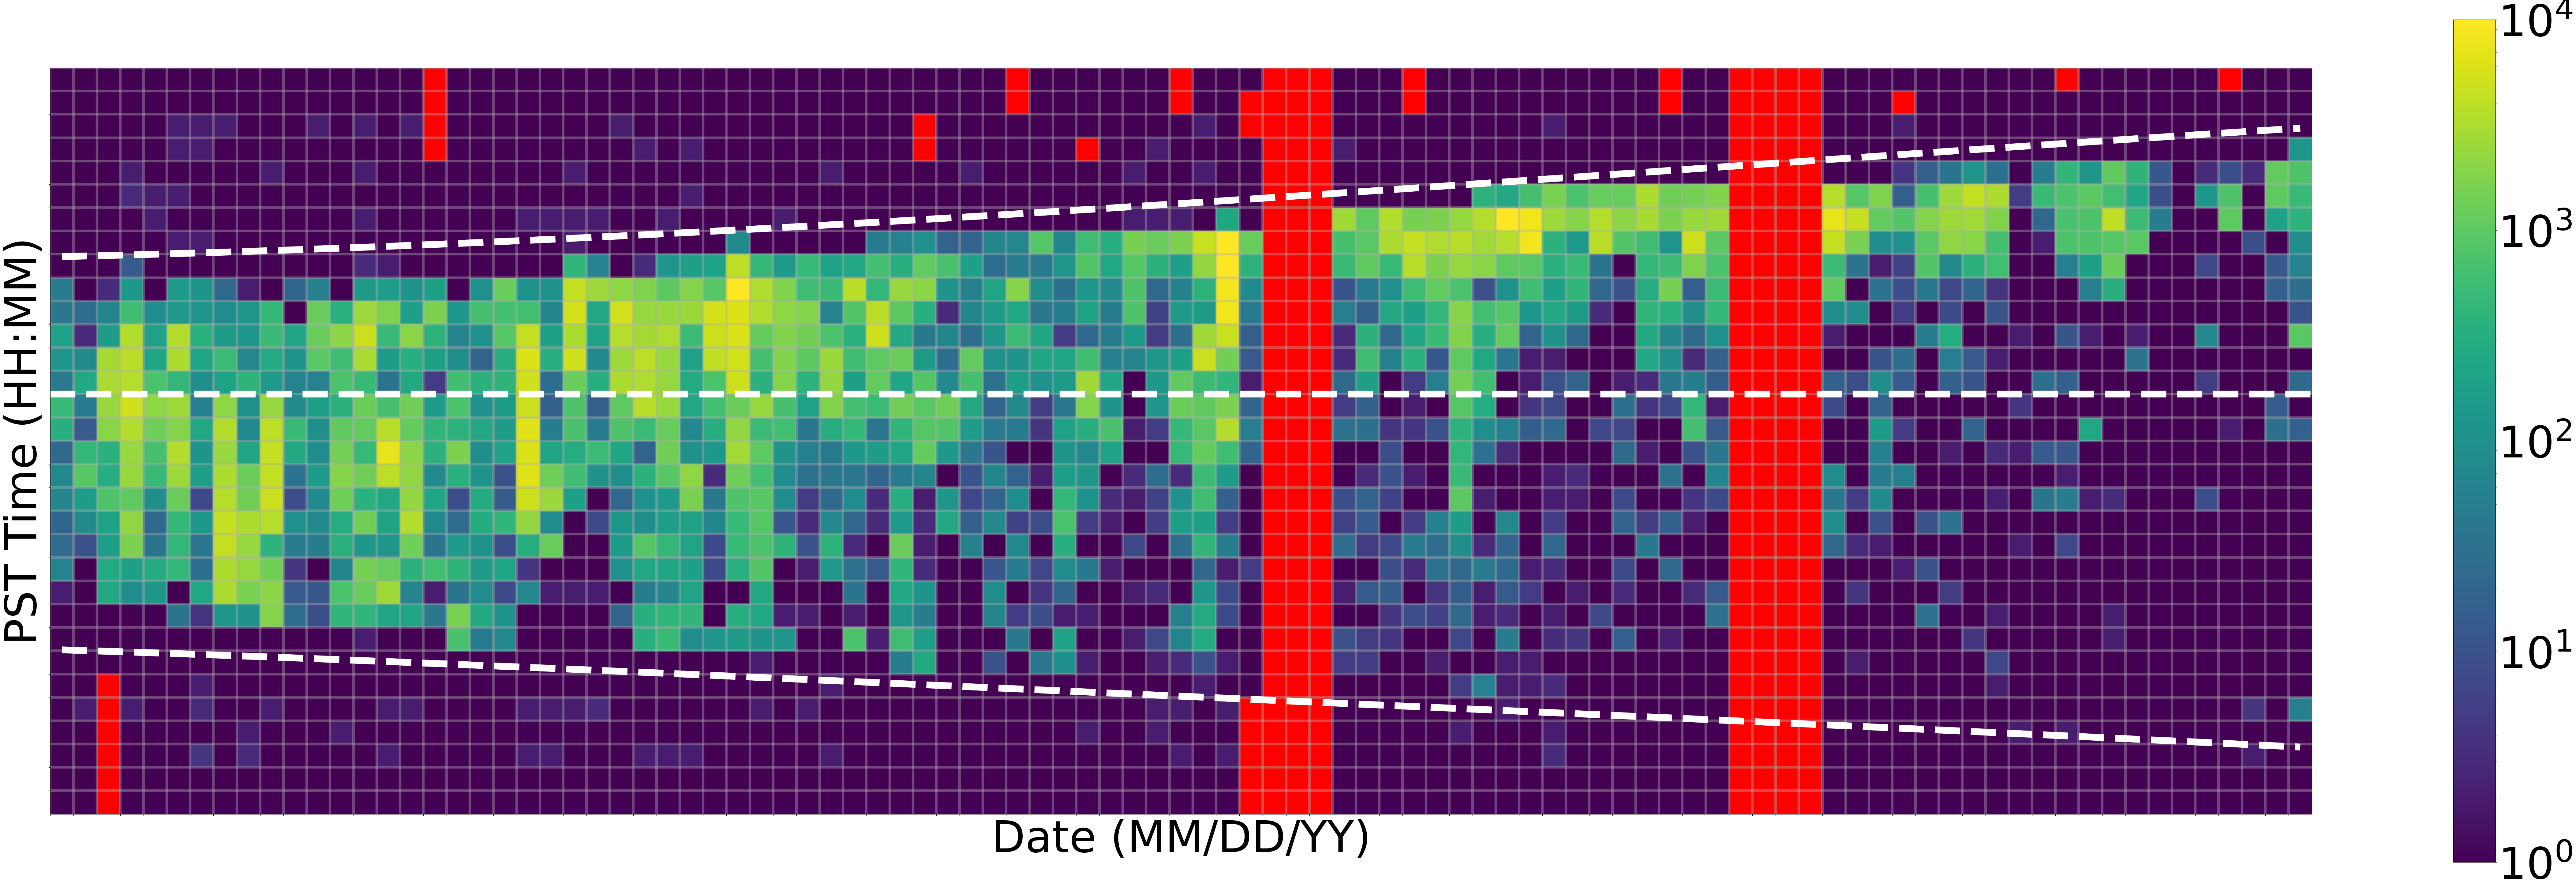

In [77]:
# activity_vals = activity_df[activity_df==activity_df.iloc[16,15]]

masked_array_for_nodets = np.ma.masked_where(activity_df.values==np.NaN, activity_df.values)
cmap = plt.get_cmap('viridis')
cmap.set_bad(color='red')
plt.rcParams.update({'font.size': (0.8*len(activity_dates) + 0.8*len(activity_times))})
plt.figure(figsize=(1*len(activity_dates), 1*len(activity_times)))
title = f"Activity (# of low-frequency calls) from {data_params['site_name']}"
# plt.title(title, fontsize=0.8*len(activity_dates) + 1.4*len(activity_times))
plt.imshow(1+(masked_array_for_nodets), cmap=cmap, norm=colors.LogNorm(vmin=1, vmax=10e3))
plt.plot(np.arange(0, len(plot_dates)), ((sunset_seconds_from_midnight / (30*60)) % len(plot_times)) - 0.5, 
        color='white', linewidth=0.5*len(activity_times), linestyle='dashed', label=f'Time of Sunset')
plt.axhline(y=np.where(activity_times=='00:00')[0]-0.5, linewidth=0.5*len(activity_times), linestyle='dashed', color='white', label='Midnight 0:00 PST')
# plt.axhline(y=np.where(activity_times=='01:00')[0]-0.5, linewidth=0.5*len(activity_times), linestyle='dashed', color='white', label='Midnight 0:00 PST')
# plt.axvline(x=np.where(activity_dates=='07/28/22')[0]-0.5, linewidth=0.5*len(activity_times), linestyle='dashed', color='white', label='Midnight 0:00 PST')
plt.plot(np.arange(0, len(plot_dates)), ((sunrise_seconds_from_midnight / (30*60)) % len(plot_times)) - 0.5, 
        color='white', linewidth=0.5*len(activity_times), linestyle='dashed', label=f'Time of Sunrise')
plt.yticks(np.arange(0, len(activity_df.index))-0.5, plot_times, rotation=30)
plt.xticks(np.arange(0, len(activity_df.columns))-0.5, plot_dates, rotation=30)
plt.ylabel(f'{ylabel} Time (HH:MM)')
plt.xlabel('Date (MM/DD/YY)')
plt.grid(which='both', linewidth=6, alpha=0.4)
# plt.legend(loc=3, ncol=3, fontsize=0.7*len(activity_dates) + 1*len(activity_times))
plt.colorbar()
plt.tight_layout()
if pipeline_params["save_activity_grid"]:
    plt.savefig(f'{file_paths["activity_grid_folder"]}/{file_paths["activity_dets_grid_figname"]}.png', bbox_inches='tight')
    plt.close()
if pipeline_params["show_plots"]:
    plt.show()